## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public Hight schools in North Carolina.** 
* Public school racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [134]:
#import required Libraries
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import cross_validate



In [135]:
#Read in the high schools dataset - NC EA Public High Schools Dataset Feb 2018

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"

ML2017 = '../Machine Learning Datasets/PublicSchools2017_ML.csv'
ML2016 = '../../2016/Machine Learning Datasets/PublicSchools2016_ML.csv'
ML2015 =  '../../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
ML2014 =  '../../2014/Machine Learning Datasets/PublicSchools2014_ML.csv'

schData2017=pd.read_csv(ML2017, low_memory=False)
print('*********************************2017 ML Data*************************************')
schData2017.info()
schData2016=pd.read_csv(ML2016, low_memory=False)
print('*********************************2016 ML Data*************************************')
schData2016.info()

schData2015=pd.read_csv(ML2015, low_memory=False)
print('*********************************2015 ML Data*************************************')
schData2015.info()

schData2014=pd.read_csv(ML2014, low_memory=False)
print('*********************************2014 ML Data*************************************')
schData2014.info()

*********************************2017 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 394 entries, student_num to unit_code
dtypes: float64(350), int64(44)
memory usage: 7.4 MB
*********************************2016 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Columns: 374 entries, closed_ind to unit_code
dtypes: float64(296), int64(78)
memory usage: 6.9 MB
*********************************2015 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Columns: 403 entries, closed_ind to unit_code
dtypes: float64(342), int64(61)
memory usage: 7.5 MB
*********************************2014 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 364 entries, closed_ind to unit_code
dtypes: float64(331), int64(

In [136]:
schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True)

C:\Users\yubin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [137]:
#Missing Data Threshold (Per Column)
missingThreshold = 0.60

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 25


#Eliminate continuous columns with more than missingThreshold percentage of missing values
schoolDataRecordCt = schData.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = schData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schData = schData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns with >= missingThreshold % of missing values******')
schData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(NullValueCols))


*********After: Removing columns with >= missingThreshold % of missing values******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9756 entries, 0 to 9755
Columns: 411 entries, (TCE) prepared returns Ct 100KLT200K to wap_per_classroom
dtypes: float64(393), int64(18)
memory usage: 30.6 MB

Columns Deleted:  107


In [138]:
#Print out all the missing value rows
pd.set_option('display.max_rows', 1000)

print('\r\n*********The Remaining Missing Values Below will be set to Zero!*************************')

#Check for Missing values 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values



*********The Remaining Missing Values Below will be set to Zero!*************************


,Variable Name,Number Missing Values
0,(TCE) prepared returns Ct 100KLT200K,4858
1,(TCE) prepared returns Ct 25KLT50K,2426
2,(TCE) prepared returns Ct 75KLT100K,2426
3,(VITA) prepared returns Ct 100KLT200K,2426
4,(VITA) prepared returns Ct 25KLT50K,2426
5,(VITA) prepared returns Ct 50KLT75K,2426
7,00_Size,2426
8,01_Size,4894
9,02_Size,2426
10,03_Size,2426


In [139]:
#Replace all remaining NaN with 0
schData = schData.fillna(0)

#Check for Missing values after final imputation 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


In [140]:
zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index
schData = schData.drop(zeroAttrition,axis=0)
print('*********After: Removing rows with first year turn over percentage =0.00******')
schData.info(verbose=False)
print ('\r\nRows Deleted: ', len(zeroAttrition))

*********After: Removing rows with first year turn over percentage =0.00******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9253 entries, 1 to 9755
Columns: 411 entries, (TCE) prepared returns Ct 100KLT200K to wap_per_classroom
dtypes: float64(393), int64(18)
memory usage: 29.1 MB

Rows Deleted:  503


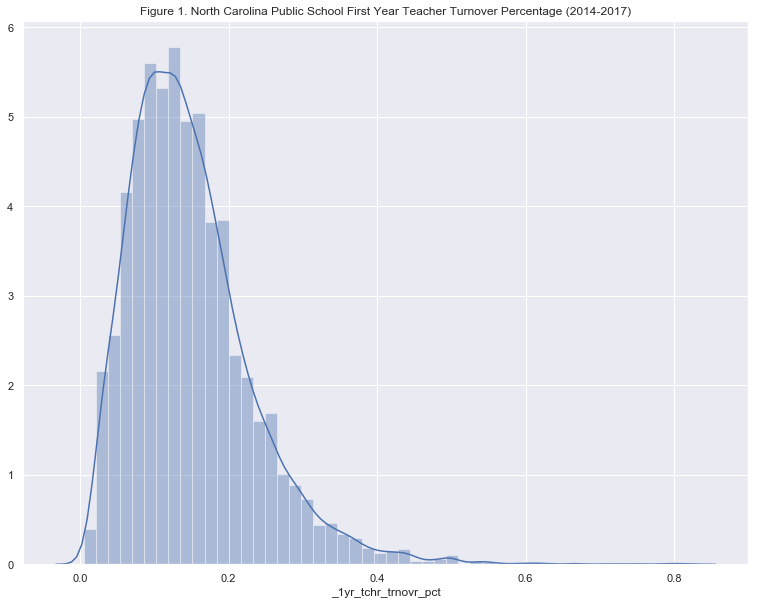

In [141]:
plt.figure(figsize=(13,10))
_1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
ax = sns.distplot(_1yr_tchr_trnovr_pct);
plt.title("Figure 1. North Carolina Public School First Year Teacher Turnover Percentage (2014-2017)")
plt.show()

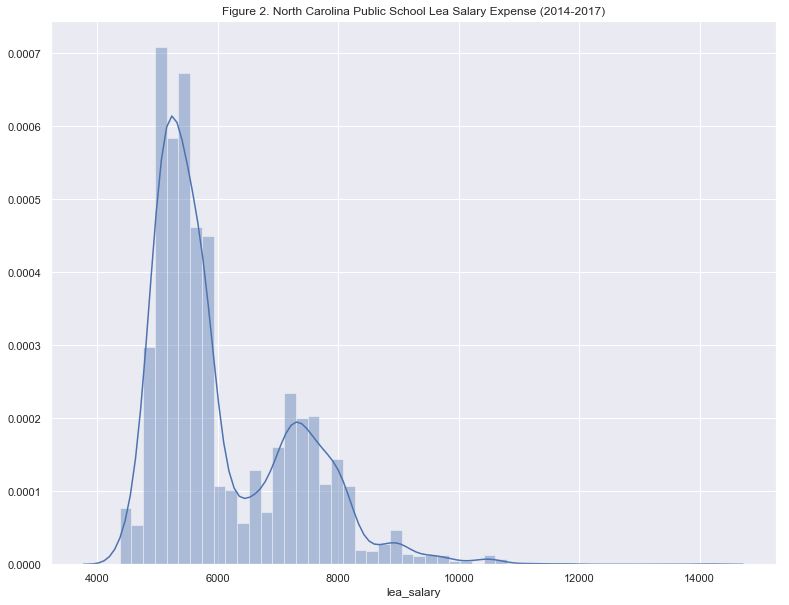

In [142]:
schData['lea_salary'] = schData['lea_total_expense_num']*schData['lea_salary_expense_pct']

plt.figure(figsize=(13,10))
lea_salary_expense_pct=schData.lea_salary_expense_pct
ax = sns.distplot(schData['lea_salary']);
plt.title("Figure 2. North Carolina Public School Lea Salary Expense (2014-2017)")
plt.show()

In [143]:
schData['_1yr_tchr_trnovr_pct'].describe()

count    9253.000000
mean        0.148518
std         0.083152
min         0.005000
25%         0.090000
50%         0.135000
75%         0.189000
max         0.818000
Name: _1yr_tchr_trnovr_pct, dtype: float64

Text(0.5,8.96,'LEA Salary Expenditure')

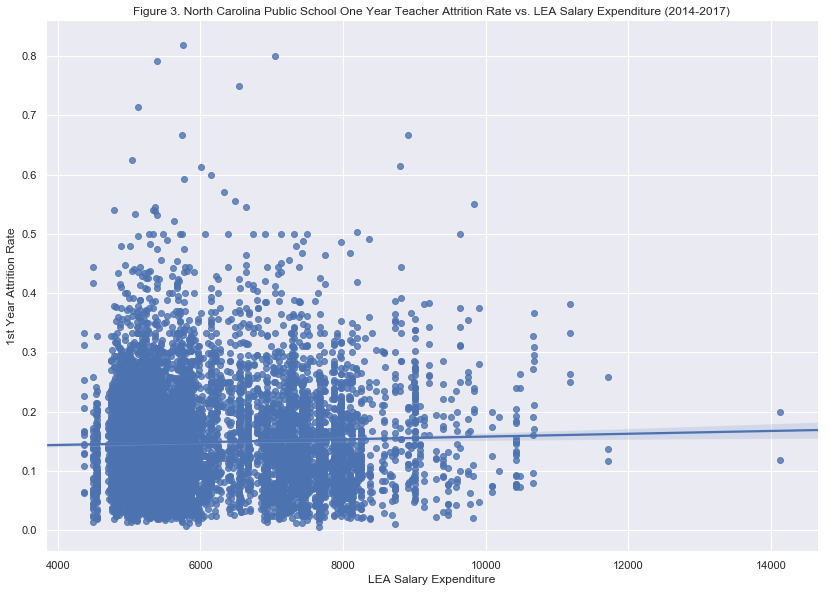

In [144]:

sns.lmplot(x="lea_salary", y="_1yr_tchr_trnovr_pct", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('LEA Salary Expenditure')

# plt.show()

Text(0.5,8.96,'LEA Total School Expenditure')

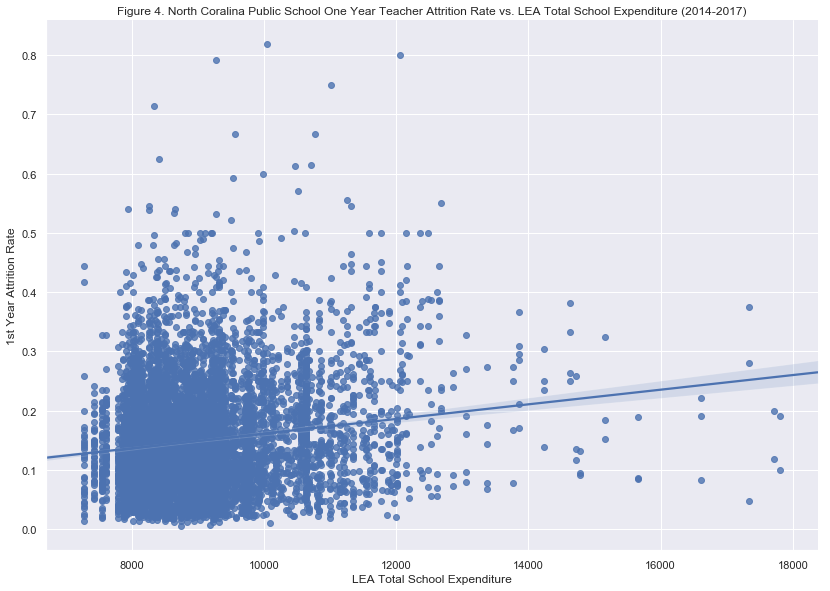

In [145]:
sns.lmplot(x="lea_total_expense_num", y="_1yr_tchr_trnovr_pct", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('LEA Total School Expenditure')


In [146]:
#schData.select_dtypes(exclude=['object']).describe()

In [147]:
#schData.info(verbose=True)

## Feature Selection

* Fit full model

In [148]:
schData_bak = schData
#schData = schData_bak

In [149]:
#schData = schData_bak

In [150]:
y= schData['_1yr_tchr_trnovr_pct']
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)

In [151]:
# Transform

saved_cols = X.columns

scaler = StandardScaler()
sch_X_scaler = scaler.fit_transform(X)
#Save as data frames
sch_X_scaler = pd.DataFrame(sch_X_scaler)
sch_X_scaler.columns = saved_cols


C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [171]:
%%time

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(sch_X_scaler.values, i) for i in range(sch_X_scaler.shape[1])]
df2_vif["ABSVIFFactor"] = abs(df2_vif["VIF Factor"])
df2_vif["features"] = sch_X_scaler.columns
df2_vif["indexes"] = range(0, len(sch_X_scaler.columns))

C:\Users\yubin\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Wall time: 3min 58s


In [172]:
df2_vif = df2_vif.sort_values('ABSVIFFactor', ascending=True)
df2_vif.to_csv('VIF_Result_ML.csv', sep=',', index=False)

In [182]:
X = sch_X_scaler

In [183]:

# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [185]:
%%time



X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3,random_state =1 )

#print("RFE CV Linear Regression 1st Pass")
rfecvEstimator = LinearRegression()

parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

#Create a grid search object  

grid = GridSearchCV(estimator=rfecvEstimator
                   #, n_jobs=8 # jobs to run in parallel
                   #, verbose=0 # low verbosity
                   , param_grid=parameters
                  )

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
grid.fit(X_train, y_train)
print("r2 / variance : ", grid.best_score_)
print("Residual sum of squares: %.2f"
              % np.mean((grid.predict(X_test) - y_test) ** 2))

C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


r2 / variance :  0.4133474102913077
Residual sum of squares: 0.00
Wall time: 2.42 s


In [186]:
%%time


#print("RFE CV Linear Regression 1st Pass")
rfecvEstimator = LinearRegression()

parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]
             }

#Create a grid search object  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
#                    , n_jobs=8 # jobs to run in parallel
#                    , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   )

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(X, y)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv,  verbose=1)
X_BestFeatures = rfecv.fit_transform(X, y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

#print("Linear Regression Second Pass")
# #create a pipeline to scale all of the data and perform logistic regression during each grid search step.
# pipe = make_pipeline(StandardScaler(), LinearRegression())

# #Define a range of hyper parameters for grid search
# parameters = { 'linearregression__fit_intercept':[True,False], 'LinearRegression__normalize':[True,False]
#               , 'LinearRegression__copy_X':[True, False]
#               , 'linearregression__n_jobs':[None]
#              }

# #Perform the grid search using accuracy as a metric during cross validation.
# grid = GridSearchCV(estimator=pipe, param_grid=parameters, cv=cv)

# #Use the best features from recursive feature elimination during the grid search
# grid.fit(X, y)

Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
Fitting estimator with 386 features.
Fitting estimator with 385 features.
F

Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
F

Fitting estimator with 372 features.
Fitting estimator with 371 features.
Fitting estimator with 370 features.
Fitting estimator with 369 features.
Fitting estimator with 368 features.
Fitting estimator with 367 features.
Fitting estimator with 366 features.
Fitting estimator with 365 features.
Fitting estimator with 364 features.
Fitting estimator with 363 features.
Fitting estimator with 362 features.
Fitting estimator with 361 features.
Fitting estimator with 360 features.
Fitting estimator with 359 features.
Fitting estimator with 358 features.
Fitting estimator with 357 features.
Fitting estimator with 356 features.
Fitting estimator with 355 features.
Fitting estimator with 354 features.
Fitting estimator with 353 features.
Fitting estimator with 352 features.
Fitting estimator with 351 features.
Fitting estimator with 350 features.
Fitting estimator with 349 features.
Fitting estimator with 348 features.
Fitting estimator with 347 features.
Fitting estimator with 346 features.
F

Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
F

Fitting estimator with 332 features.
Fitting estimator with 331 features.
Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
Fitting estimator with 327 features.
Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
F

Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator 

Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
Fitting estimator with 290 features.
Fitting estimator with 289 features.
Fitting estimator with 288 features.
Fitting estimator with 287 features.
Fitting estimator with 286 features.
Fitting estimator with 285 features.
Fitting estimator with 284 features.
Fitting estimator with 283 features.
Fitting estimator with 282 features.
Fitting estimator with 281 features.
Fitting estimator with 280 features.
Fitting estimator with 279 features.
Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
F

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 fe

Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
F

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 fea

Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
F

Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
Fitting estimator with 386 features.
Fitting estimator with 385 features.
Fitting estimator with 384 features.
Fitting estimator with 383 features.
Fitting estimator with 382 features.
Fitting estimator with 381 features.
Fitting estimator with 380 features.
Fitting estimator with 379 features.
Fitting estimator with 378 features.
Fitting estimator with 377 features.
Fitting estimator with 376 features.
Fitting estimator with 375 features.
Fitting estimator with 374 features.
Fitting estimator with 373 features.
Fitting estimator with 372 features.
Fitting estimator with 371 features.
Fitting estimator with 370 features.
Fitting estimator with 369 features.
Fitting estimator with 368 features.
Fitting estimator with 367 features.
F

Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
F

Fitting estimator with 354 features.
Fitting estimator with 353 features.
Fitting estimator with 352 features.
Fitting estimator with 351 features.
Fitting estimator with 350 features.
Fitting estimator with 349 features.
Fitting estimator with 348 features.
Fitting estimator with 347 features.
Fitting estimator with 346 features.
Fitting estimator with 345 features.
Fitting estimator with 344 features.
Fitting estimator with 343 features.
Fitting estimator with 342 features.
Fitting estimator with 341 features.
Fitting estimator with 340 features.
Fitting estimator with 339 features.
Fitting estimator with 338 features.
Fitting estimator with 337 features.
Fitting estimator with 336 features.
Fitting estimator with 335 features.
Fitting estimator with 334 features.
Fitting estimator with 333 features.
Fitting estimator with 332 features.
Fitting estimator with 331 features.
Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
F

Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
F

Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.
Fitting estimator with 296 features.
Fitting estimator with 295 features.
Fitting estimator with 294 features.
Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
Fitting estimator with 290 features.
Fitting estimator with 289 features.
Fitting estimator with 288 features.
F

Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 fe

Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
F

Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 fe

Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
F

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [187]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [188]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [189]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults


## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [190]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [191]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False),'normalize': (True, False),}

#Create a grid search object using the  
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    7.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [192]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False)

## Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP predictions between 0 and 100% 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [193]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X, y, cv)


The average MAE for all cv folds is: 			 0.044606
The average MAE percentage (MAPE) for all cv folds is: 	 43.937
The average RMSE for all cv folds is: 			 0.059839
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.044149,44.165423,0.058250
1,0.045057,46.842873,0.060953
2,0.044693,43.133518,0.060829
3,0.045202,44.492489,0.060770
4,0.045331,45.211347,0.060597
5,0.042494,43.475703,0.057706
6,0.043951,42.897730,0.060393
7,0.044187,41.614489,0.057309
8,0.045191,45.876587,0.059947
9,0.045805,41.657616,0.061635


## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [ ]:
# #Create a Linear regression object and perform a grid search to find the best parameters
# from sklearn.svm import SVR
# reg = SVR()

# #Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
# costs = [0.001, 0.1]
# defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
# gammas = [defGamma, 0.1]
# kernels = ['rbf','linear']
# parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

# #Create a grid search object using the parameters above
# from sklearn.model_selection import GridSearchCV
# regGridSearch = GridSearchCV(estimator=reg
#                    , n_jobs=8 # jobs to run in parallel
#                    , verbose=1 # low verbosity
#                    , param_grid=parameters
#                    , cv=cv # KFolds = 10
#                    , scoring=mae_scorer)

# #Perform hyperparameter search to find the best combination of parameters for our data
# regGridSearch.fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [9]:
#Display the best estimator parameters
regGridSearch.best_estimator_

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [12]:
# from sklearn.svm import SVR

# #Create a regression estimator with best parameters for cross validation
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# #Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
# EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 8.1889
The average MAE percentage (MAPE) for all cv folds is: 	 6.7091
The average RMSE for all cv folds is: 			 14.651
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,11.887309,7.095543,24.075882
1,10.053245,7.231779,20.190535
2,11.691543,6.865657,24.012163
3,9.427670,6.437708,19.953082
4,6.406394,7.317697,7.682569
5,8.440394,7.532731,15.323706
6,7.350904,5.925200,14.788742
7,5.908479,6.738445,7.151269
8,5.776649,6.380496,6.964493
9,4.946862,5.565430,6.364902


In [13]:
#Do we predict graduation rates greater than 100%?
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# regEstimator.fit(X_highSchools, Y)
# yhat = regEstimator.predict(X_highSchools)
# print("Yhat Max: ", yhat.max())

('Yhat Max: ', 90.90050000000001)


## Graduation Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [194]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   12.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [195]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

In [196]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.062496
The average MAE percentage (MAPE) for all cv folds is: 	 66.591
The average RMSE for all cv folds is: 			 0.082683
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.062176,69.868814,0.078837
1,0.063023,71.341595,0.081707
2,0.063026,66.518840,0.083470
3,0.062334,63.677161,0.081583
4,0.065547,69.394370,0.088842
5,0.061313,68.350009,0.082444
6,0.063292,66.696724,0.087050
7,0.059138,61.457046,0.078201
8,0.063966,68.188756,0.084570
9,0.061147,60.417508,0.080121


In [197]:
#Do we predict graduation rates greater than 100%?
regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X, y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.14851810223711226


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [198]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  4.1min finished
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [199]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

In [200]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X, y, cv)

C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

The average MAE for all cv folds is: 			 0.044376
The average MAE percentage (MAPE) for all cv folds is: 	 43.718
The average RMSE for all cv folds is: 			 0.059566
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,MAE,MAPE,RMSE
0,0.044078,44.081746,0.058220
1,0.044842,46.339217,0.060426
2,0.044625,43.078312,0.060781
3,0.044874,44.292835,0.060304
4,0.045197,45.188431,0.060460
5,0.042338,43.384875,0.057514
6,0.043743,42.734083,0.060206
7,0.043326,40.825469,0.056346
8,0.045046,45.716434,0.059871
9,0.045691,41.541247,0.061534


In [201]:
#Do we predict graduation rates greater than 100%?
regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

regEstimator.fit(X, y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.6413364168216475


## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [202]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   34.1s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:   40.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [203]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='random', tol=0.0001, warm_start=True)

In [206]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.053094
The average MAE percentage (MAPE) for all cv folds is: 	 55.353
The average RMSE for all cv folds is: 			 0.070072
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.051682,55.958464,0.065910
1,0.053231,58.640376,0.068987
2,0.053778,55.293917,0.071522
3,0.053466,53.800524,0.069856
4,0.055615,57.889262,0.074158
5,0.051932,57.532867,0.069672
6,0.052881,55.387337,0.073066
7,0.050613,51.072803,0.066757
8,0.054658,56.682354,0.071424
9,0.053088,51.273662,0.069372


In [207]:
#Do we predict graduation rates greater than 100%?
regEstimator =  regGridSearch.best_estimator_

regEstimator.fit(X, y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.3185123160069001
